# Detecting Splice Junctions using Convolutional Neural Networks
This iPython notebook contains all the code necessary to replicate the evaluations from the writeup, along with some explanations of how the code works. Run the notebook cell-by-cell to follow along!

### Importing Numpy
As the first step, we import NumPy, which is used extensively throughout the rest of the notebook for easier numerical computing.

In [1]:
import numpy as np

### Reading and Parsing Data
The data, sourced from [this repository](https://archive.ics.uci.edu/ml/datasets/Molecular+Biology+(Splice-junction+Gene+Sequences), is in a comma-separated format, so we first must split each row along the commas and clean up the data.

In [2]:
fname = 'splice.data'
with open(fname) as f:
    content = f.readlines()
content = [x.strip().split(',') for x in content]
for l in content:
    for i in range(len(l)):
        l[i] = l[i].strip()
raw_data = np.array(content)

Next, we define a function, `getInstanceFromRow`, that takes in one 'row' of clean input from the file, and in return outputs an x and y -- i.e., a sequence and its label respectively. Sequences are represented orthogonally, where the four axes represent the four bases: Adenine (A), Cytosine (C), Guanine (G) and Thymine (T). The dataset being used contains some missing bases, as described on [this README](https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/splice-junction-gene-sequences/splice.names). To represent these, we uniformly a weight of 1 among the possible underlying bases. The labels are returned in a one-hot encoding format, where class 0 is an exon-to-intron junction, class 1 is an intron-to-exon junction, and class 2 represents the absence of a splice junction.

In [3]:
def getInstanceFromRow(row):
    one_hot = np.zeros((1, 3))
    label = row[0]
    if label == 'EI':
        one_hot[0][0] = 1
    elif label == 'IE':
        one_hot[0][1] = 1
    else:
        one_hot[0][2] = 1
    orth = np.zeros((len(row[2]), 4))
    for i in range(len(row[2])):
        c = row[2][i]
        if c == 'A':
            orth[i][0] = 1
        elif c == 'C':
            orth[i][1] = 1
        elif c == 'G':
            orth[i][2] = 1
        elif c == 'T':
            orth[i][3] = 1
        elif c == 'D':
            orth[i][0] = 1/3.
            orth[i][2] = 1/3.
            orth[i][3] = 1/3.
        elif c == 'N':
            orth[i][0] = 1/4.
            orth[i][1] = 1/4.
            orth[i][2] = 1/4.
            orth[i][3] = 1/4.
        elif c == 'S':
            orth[i][1] = 1/2.
            orth[i][2] = 1/2.
        elif c == 'R':
            orth[i][0] = 1/2.
            orth[i][2] = 1/2.
    return orth, one_hot

Finally, we use the above function to aggregate our dataset into two arrays, `x` and `y`, containing the inputs and labels respectively. Note that it is important to shuffle the dataset, since it is ordered by labels to start with.

In [45]:
x = []
y = []
for i in range(raw_data.shape[0]):
    xi, yi = getInstanceFromRow(raw_data[i])
    x.append(xi)
    y.append(yi)
x = np.array(x)
y = np.array(y)

# Shuffle dataset since it's unevenly distributed
shuffle_index = np.random.permutation(len(x))
x = x[shuffle_index]
y = y[shuffle_index]

# Conv1D expects channels first
x = np.swapaxes(x, 1, 2)
print (str(x.shape[0]) + " examples parsed.")

3190 examples parsed.


# Learning to detect junctions using a convolutional network
The next section uses the Keras framework to put together a small convolutional network, which is then trained and evaluated on the dataset parsed above. The first step is to organize our imports for this section.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, Dropout, MaxPooling1D
from keras import backend as K
K.set_learning_phase(True)

Using TensorFlow backend.


Next, we describe the actual architecture of the network, as described in the writeup.

In [46]:
model = Sequential()
model.add(Conv1D(8, 3, input_shape=(None, 60), padding='same', name='conv1'))
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Conv1D(16, 3, padding='same', name='conv2'))
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Dense(3, name='fc1'))
model.add(Dropout(0.5))
model.add(Activation('softmax'))

The architecture needs to be accompanied by a loss function, and an optimizer that will aim to minimize the loss function during the training process. In our case, we can use the categorical cross-entropy loss, which is typically used in classification settings. We use the Adam optimizer -- a commonly used optimizer -- to minimize the loss.

In [47]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Finally, we can start the training process. We fit the model on the dataset from above, while splitting it into a training set and a validation set. The validation set is not used for training -- it is simply used to track the accuracy of the network on unseen data as training progresses.

In [48]:
model.fit(x, y, epochs=30, batch_size=32, validation_split=0.1, shuffle=True)
K.set_learning_phase(False)

Train on 2871 samples, validate on 319 samples
Epoch 1/30
2871/2871 [==============================] - 4s 1ms/step - loss: 1.0321 - acc: 0.4835 - val_loss: 0.9841 - val_acc: 0.5141
Epoch 2/30
2871/2871 [==============================] - 1s 198us/step - loss: 0.8920 - acc: 0.5604 - val_loss: 0.7960 - val_acc: 0.6489
Epoch 3/30
2871/2871 [==============================] - 1s 181us/step - loss: 0.6093 - acc: 0.7792 - val_loss: 0.4681 - val_acc: 0.8433
Epoch 4/30
2871/2871 [==============================] - 0s 162us/step - loss: 0.3437 - acc: 0.8927 - val_loss: 0.2916 - val_acc: 0.9060
Epoch 5/30
2871/2871 [==============================] - 0s 157us/step - loss: 0.2221 - acc: 0.9377 - val_loss: 0.2183 - val_acc: 0.9310
Epoch 6/30
2871/2871 [==============================] - 0s 162us/step - loss: 0.1638 - acc: 0.9554 - val_loss: 0.1943 - val_acc: 0.9310
Epoch 7/30
2871/2871 [==============================] - 0s 146us/step - loss: 0.1338 - acc: 0.9641 - val_loss: 0.1693 - val_acc: 0.9404
Epo

# Visualizing the knowledge learned by the network
The main purpose of this exercise is to dig into the representation learned by the convolutional network. To do so, several techniques, as described in the writeup, are implemented. Before going into those, we import and set up some useful visualization tools from Matplotlib.

In [24]:
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"] = [15, 10]

## Visualizing classes using gradient ascent
To visualize what the network thinks a particular class looks like, we can start with a null sequence (filled with 'N' symbols) and repeatedly change it to move in the direction of the class being visualized. We can then use this function to check what the network thinks an intron-to-exon junction, for example, should look like.

In [80]:
# class_name should be one of EI, IE or N
def visualizeClass(class_name):
    filter_index = -1
    if class_name == 'EI':
        filter_index = 0
    elif class_name == 'IE':
        filter_index = 1
    elif class_name == 'N':
        filter_index = 2
    else:
        print("class_name must be one of EI (exon->intron), IE (intron->exon), or N (neither)!")
        return
    
    loss = K.mean(model.output[:, :, filter_index])
    input_seq = model.input
    grads = K.gradients(loss, input_seq)[0]
    iterate = K.function([input_seq], [loss, grads])
    sequence = np.zeros((1, 4, 60))
    sequence[:] = 0.25
    step_size = 1. # Gradient ascent step size
    
    # Perform gradient ascent in the direction of the target class
    for i in range(30):
        loss_value, grads_value = iterate([sequence])
        sequence += grads_value * step_size
    
    sequence[0] /= np.linalg.norm(sequence[0], 1, axis=0)
    sequence = np.clip(sequence, 0, 1)
    
    plt.title(class_name + " Visualization")
    plt.imshow(sequence[0], cmap='viridis')
    plt.xticks(np.arange(60), np.arange(60)+1)
    plt.yticks(np.arange(4), ('A', 'C', 'G', 'T'))
    # Uncomment the line below to save the figure as an image
    # plt.savefig('ClassVisualization' + class_name + '.png')
    plt.show()

Now, we can visualize our learned representations for each class as follows:

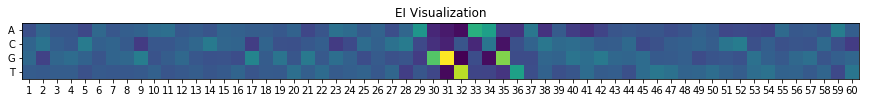

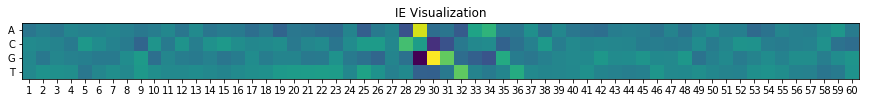

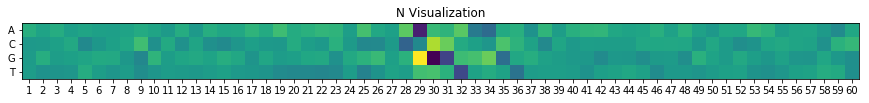

In [81]:
visualizeClass("EI")
visualizeClass("IE")
visualizeClass("N")

## Saliency Maps
Why does the network make a certain prediction? What part of the input sequence is most important in producing the prediction? We can visualize this using saliency maps. We simply propagate the given sequence through the network, and then assess the computed gradients at the prediction output.

We start by writing a helper function that is used by the visualization code. This function simply maps the orthogonal input representation back into a compact string sequence.

In [50]:
def sequenceFromOrthogonal(s):
    s = s.T
    l = []
    for i in range(len(s)):
        if s[i][0] == 1.:
            l.append('A')
        elif s[i][1] == 1.:
            l.append('C')
        elif s[i][2] == 1.:
            l.append('G')
        elif s[i][3] == 1.:
            l.append('T')
        elif s[i][0] == 1/3. and s[i][2] == 1/3. and s[i][3] == 1/3.:
            l.append('D')
        elif s[i][0] == 1/4. and s[i][1] == 1/4. and s[i][2] == 1/4. and s[i][3] == 1/4.:
            l.append('N')
        elif s[i][1] == 1/2. and s[i][2] == 1/2.:
            l.append('S')
        elif s[i][0] == 1/2. and s[i][2] == 1/2.:
            l.append('R')
    return l

Next, we implement the saliency map visualization.

In [69]:
# example_index is the index between 0 and 3189 of the example whose saliency map is to be visualized.
def saliencyMap(example_index):
    
    # Step 1: retrieve the example from the dataset, get the network's prediction
    print ("Ground truth label: " + str(np.argmax(y[example_index])))
    prediction = np.argmax(model.predict(np.array([x[example_index]]))[0][0])
    print ("Predicted label: " + str(prediction))
    
    loss = K.mean(model.output[:, :, prediction])
    input_seq = model.input
    grads = K.gradients(loss, input_seq)[0]
    salience = K.function([input_seq], [loss, grads])
    sequence = np.zeros((1, 4, 60))
    sequence[0,:] = x[example_index]
    
    loss_value, grads_value = salience([sequence])
    saliency_map = grads_value[0] * x[example_index]
    saliency_map = np.sum(saliency_map, axis=0).reshape(1, 60)
    
    plt.xticks(np.arange(60), sequenceFromOrthogonal(x[example_index]))
    plt.yticks([])
    plt.imshow(saliency_map, cmap='viridis')
    # Uncomment the line below to save the saliency map as an image
    # plt.savefig('SaliencyMap' + str(example_index) + '.png')
    plt.show()

Ground truth label: 0
Predicted label: 0


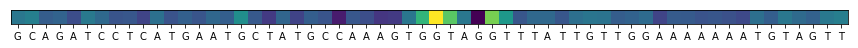

In [79]:
saliencyMap(77)